In [5]:
import lorm
from nfft import nfft
import disc.energy_curveling_2d
import numpy as np
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline
img = 256-plt.imread('data/eyeofthetiger.jpg')
img_N_half = int(img.shape[0]/2)

M = 2*img_N_half
x = np.linspace(-0.5,0.5,M,endpoint=False)
x1,x2 = np.meshgrid(x,x)
quat_nodes = np.array([x1.ravel()[:],-x2.ravel()[:]]).transpose()
mu = img[:]
#plt.imshow(256-mu.reshape(M,M))

nfft2d = nfft.NFFT2D(M**2,2*img_N_half,2*img_N_half)
nfft2d.x = quat_nodes
nfft2d.precompute_x()
nfft2d.f = mu/M**2
nfft2d.adjoint()
mu_hat = np.zeros([2*img_N_half,2*img_N_half],dtype=np.complex)
mu_hat[:] = nfft2d.f_hat/nfft2d.f_hat[img_N_half,img_N_half]

In [27]:
e2 = lorm.manif.EuclideanSpace(2)
points = lorm.manif.ManifoldPointArray(e2)
m = 96
t = np.linspace(0,2*np.pi,m,endpoint=False)
points.coords = np.zeros([m,2])
points.coords[:,1] = 0.2*np.cos(t)
points.coords[:,0] = 0.2*np.sin(t)
points_new = lorm.manif.ManifoldPointArray(e2)
L = 0.97*np.sqrt(2)*4

In [28]:
for k in range(2*3):
    N_half = 4*np.int(L/0.97)
    N=2*N_half
    m = points.coords.shape[0]
    energy = disc.energy_curveling_2d.plan(m,N,0.5,L)
    if img_N_half >= N_half:
        energy._mu_hat[:] = mu_hat[img_N_half-N_half:img_N_half+N_half,img_N_half-N_half:img_N_half+N_half]
    else:
        energy._mu_hat[N_half-img_N_half:N_half+img_N_half,N_half-img_N_half:N_half+img_N_half] = mu_hat[:]
    points_new.coords = np.zeros([m,2])

    print(N,m,energy._equality_constraint)
    
    energy._alpha = 100/energy._L**5
    method= lorm.optim.ConjugateGradientMethod(max_iter=100,tol_grad=1e-12)
    points_new.coords[:] = points.coords[:]
    points_new = method.run(energy,points_new)
    
    np.savetxt("data/tiger_{}.txt".format(k),points_new.coords)
    
    tempc = points_new.coords
    m2 = len(tempc)
    temp = np.zeros([2*m2,2])
    for i in range(m2):
        temp[2*i,:] = tempc[i,:]
    for i in range(m2-1):
        temp[2*i+1,:] = (tempc[i,:]+tempc[i+1,:])/2
    temp[2*m2-1,:] = (tempc[0,:]+tempc[m2-1,:])/2

    points.coords = temp
    
    m = points.coords.shape[0]
    energy = disc.energy_curveling_2d.plan(m,N,0.5,L)
    if img_N_half >= N_half:
        energy._mu_hat[:] = mu_hat[img_N_half-N_half:img_N_half+N_half,img_N_half-N_half:img_N_half+N_half]
    else:
        energy._mu_hat[N_half-img_N_half:N_half+img_N_half,N_half-img_N_half:N_half+img_N_half] = mu_hat[:]
    points_new.coords = np.zeros([m,2])
    
    energy._L = L/0.97
    energy._alpha = 10000/(energy._L)**5
    method= lorm.optim.ConjugateGradientMethod(max_iter=100,tol_grad=1e-12)
    points_new.coords[:] = points.coords[:]
    for l in range(k):
        points_new = method.run(energy,points_new)
    
    np.savetxt("data/tiger_{}_refined.txt".format(k),points_new.coords)
        
    L*=np.sqrt(2)

40 96 False
Initial value: f[0] = 0.8655322380905368
f[1] = 0.39550281428654777
f[2] = 0.30349274421364303
f[3] = 0.08020744173574627
f[4] = 0.05988537758814118
f[5] = 0.048672012672951896
f[6] = 0.04143339832092881
f[7] = 0.037042321808915125
f[8] = 0.0346162610470552
f[9] = 0.032557883583027906
f[10] = 0.03055440061600383
f[11] = 0.028660837750139376
f[12] = 0.026957832287488458
f[13] = 0.026034464703585107
f[14] = 0.02526292938222599
f[15] = 0.024620977917561297
f[16] = 0.02403793763161361
f[17] = 0.023572306892615094
f[18] = 0.02314174083199286
f[19] = 0.022800399792012316
f[20] = 0.022457354335796504
f[21] = 0.0221371421491732
f[22] = 0.021730658790639474
f[23] = 0.021305308671584013
f[24] = 0.0208714183976047
f[25] = 0.02048950536059647
f[26] = 0.020136033251321683
f[27] = 0.019816767021652453
f[28] = 0.019455342027232172
f[29] = 0.018991363591239718
f[30] = 0.0186360407276444
f[31] = 0.018230919115148705
f[32] = 0.01796553876714798
f[33] = 0.017735705737030375
f[34] = 0.01752205

f[85] = 0.004727452198463702
f[86] = 0.004726278313803223
f[87] = 0.004725012690332663
f[88] = 0.004723860015196265
f[89] = 0.0047226954347920624
f[90] = 0.004721699233657949
f[91] = 0.004720460712632474
f[92] = 0.0047193078505723485
f[93] = 0.0047182281416206055
f[94] = 0.004717272424634569
f[95] = 0.004716498829208525
f[96] = 0.004715728681902196
f[97] = 0.004715110671717517
f[98] = 0.004714588657745063
f[99] = 0.00471409460788101
f[100] = 0.004713672605622605
Reached maximal iterations!
88 384 False
Initial value: f[0] = 0.004896286883007301
f[1] = 0.003225822560207183
f[2] = 0.003068670556604821
f[3] = 0.002960518355692638
f[4] = 0.0028351236717759384
f[5] = 0.00269924701012901
f[6] = 0.002573616961989735
f[7] = 0.0024818410256547976
f[8] = 0.0024222274694409495
f[9] = 0.0023619863671654334
f[10] = 0.0023037185881282832
f[11] = 0.002257219854152009
f[12] = 0.0022254530530741554
f[13] = 0.002199662976356379
f[14] = 0.0021785931770064997
f[15] = 0.002163356348631129
f[16] = 0.0021514

f[60] = 0.0017136690882957487
f[61] = 0.00171348066433026
f[62] = 0.0017132299084343442
f[63] = 0.0017128995931075446
f[64] = 0.001712598795349951
f[65] = 0.0017123315313939164
f[66] = 0.0017121115873711624
f[67] = 0.001711911017267475
f[68] = 0.001711740676469245
f[69] = 0.0017115663158033278
f[70] = 0.0017114193130471978
f[71] = 0.0017112970446635308
f[72] = 0.0017111868286517993
f[73] = 0.0017111001209963745
f[74] = 0.0017110284202128173
f[75] = 0.0017109629795436275
f[76] = 0.0017109035410558817
f[77] = 0.0017108524708060657
f[78] = 0.0017108014259275513
f[79] = 0.0017107509320520235
f[80] = 0.0017106958604375748
f[81] = 0.001710635625597583
f[82] = 0.0017105683862486752
f[83] = 0.001710501994930812
f[84] = 0.001710432746554261
f[85] = 0.0017103673522764148
f[86] = 0.0017103083698202823
f[87] = 0.0017102575512913836
f[88] = 0.0017102070023653191
f[89] = 0.0017101629950405611
f[90] = 0.0017101150963125943
f[91] = 0.0017100679887494565
f[92] = 0.0017100270172769746
f[93] = 0.00170997

f[30] = 0.0006262662540875874
f[31] = 0.0006260802097535512
f[32] = 0.0006259186640811996
f[33] = 0.0006257731631372786
f[34] = 0.0006256535800606027
f[35] = 0.0006255603865672197
f[36] = 0.0006254692122692957
f[37] = 0.000625385523521845
f[38] = 0.0006253050053347363
f[39] = 0.0006252227809601901
f[40] = 0.0006251435166738072
f[41] = 0.0006250629400859152
f[42] = 0.0006249909324970238
f[43] = 0.0006249315121864552
f[44] = 0.0006248661547077354
f[45] = 0.0006248011055373778
f[46] = 0.0006247318701064399
f[47] = 0.0006246701284926779
f[48] = 0.0006246158444177549
f[49] = 0.0006245662901966022
f[50] = 0.0006245210936625483
f[51] = 0.0006244818340462915
f[52] = 0.0006244431079893117
f[53] = 0.0006244072462569077
f[54] = 0.0006243720599892825
f[55] = 0.0006243372245645707
f[56] = 0.0006243052272593909
f[57] = 0.0006242739473305941
f[58] = 0.0006242448978361037
f[59] = 0.0006242118565464941
f[60] = 0.0006241767537835377
f[61] = 0.0006241445986478907
f[62] = 0.0006241119702288798
f[63] = 0.0

Initial value: f[0] = 0.0004672144637164481
f[1] = 0.0004484247494102437
f[2] = 0.00038358756220334205
f[3] = 0.00035736146033680226
f[4] = 0.00033662025935294205
f[5] = 0.0003158003821195582
f[6] = 0.0003005668916854274
f[7] = 0.0002871310483833307
f[8] = 0.0002776028759230612
f[9] = 0.00026904196071440205
f[10] = 0.00026297716485381974
f[11] = 0.00025768608016998347
f[12] = 0.00025399529659804666
f[13] = 0.00025106518968199035
f[14] = 0.00024897417761486125
f[15] = 0.00024752216465078397
f[16] = 0.00024635300649515147
f[17] = 0.0002455145100962054
f[18] = 0.00024493622547141163
f[19] = 0.00024453756523888176
f[20] = 0.00024421046072669705
f[21] = 0.00024388162350388713
f[22] = 0.00024361706969883328
f[23] = 0.00024340644527306974
f[24] = 0.00024326711702308748
f[25] = 0.00024313403454531734
f[26] = 0.00024299300823904483
f[27] = 0.00024285509477869188
f[28] = 0.00024274448351012376
f[29] = 0.00024265655190940493
f[30] = 0.00024250264883740673
f[31] = 0.0002423654078328029
f[32] = 0.0

f[65] = 0.0002293256295698688
f[66] = 0.0002293199789527534
f[67] = 0.00022931424518394955
f[68] = 0.00022930840310251275
f[69] = 0.00022930283182485487
f[70] = 0.00022929721661172177
f[71] = 0.00022929228975881693
f[72] = 0.00022928791119721737
f[73] = 0.00022928381850982418
f[74] = 0.00022928014188775873
f[75] = 0.00022927619645804473
f[76] = 0.00022927209207914258
f[77] = 0.0002292676313111046
f[78] = 0.00022926316589715455
f[79] = 0.0002292584573132588
f[80] = 0.00022925378548202522
f[81] = 0.00022924882818700686
f[82] = 0.00022924332461067042
f[83] = 0.00022923716018322451
f[84] = 0.0002292307623853928
f[85] = 0.00022922464100636126
f[86] = 0.00022921868037511085
f[87] = 0.000229212829307381
f[88] = 0.00022920758787198944
f[89] = 0.00022920261507999528
f[90] = 0.00022919769691469403
f[91] = 0.00022919274358137141
f[92] = 0.0002291879566552112
f[93] = 0.0002291838328316159
f[94] = 0.0002291797238045576
f[95] = 0.00022917590921048384
f[96] = 0.0002291722064814057
f[97] = 0.000229168

f[29] = 9.212772536030414e-05
f[30] = 9.208820936332391e-05
f[31] = 9.204042174498367e-05
f[32] = 9.198617611531135e-05
f[33] = 9.192482756205835e-05
f[34] = 9.185384211510259e-05
f[35] = 9.177119970329642e-05
f[36] = 9.170922921239127e-05
f[37] = 9.16492117991178e-05
f[38] = 9.158996491286388e-05
f[39] = 9.152950661967435e-05
f[40] = 9.145947716746442e-05
f[41] = 9.137298016382739e-05
f[42] = 9.128792082827335e-05
f[43] = 9.120533354254805e-05
f[44] = 9.112211995987667e-05
f[45] = 9.10293767112557e-05
f[46] = 9.092511093650831e-05
f[47] = 9.081612788103423e-05
f[48] = 9.071872992479599e-05
f[49] = 9.065060541952402e-05
f[50] = 9.058991591984348e-05
f[51] = 9.05276914834243e-05
f[52] = 9.045419250505996e-05
f[53] = 9.036709992813849e-05
f[54] = 9.027538935411356e-05
f[55] = 9.01787123180399e-05
f[56] = 9.007881506250405e-05
f[57] = 8.998916304408006e-05
f[58] = 8.990107959612242e-05
f[59] = 8.981053220457825e-05
f[60] = 8.972889504377344e-05
f[61] = 8.964770409275761e-05
f[62] = 8.9572

f[100] = 8.572781466209294e-05
Reached maximal iterations!
Initial value: f[0] = 8.572781466209294e-05
f[1] = 8.572702532462173e-05
f[2] = 8.572665300915062e-05
f[3] = 8.572629522315014e-05
f[4] = 8.572592169711263e-05
f[5] = 8.572552328585685e-05
f[6] = 8.57250493525705e-05
f[7] = 8.572451805459246e-05
f[8] = 8.572398381154737e-05
f[9] = 8.572337174955779e-05
f[10] = 8.572266370658747e-05
f[11] = 8.572187261838548e-05
f[12] = 8.572103138846457e-05
f[13] = 8.57199544253556e-05
f[14] = 8.571883017606675e-05
f[15] = 8.571768449475021e-05
f[16] = 8.571648694491578e-05
f[17] = 8.571517183760395e-05
f[18] = 8.571379458239975e-05
f[19] = 8.571252143466135e-05
f[20] = 8.571120853058785e-05
f[21] = 8.570993281876306e-05
f[22] = 8.570842450782963e-05
f[23] = 8.570677207691605e-05
f[24] = 8.570521692943048e-05
f[25] = 8.570376220211757e-05
f[26] = 8.570231357283094e-05
f[27] = 8.570087991404508e-05
f[28] = 8.569932440910224e-05
f[29] = 8.569749633570637e-05
f[30] = 8.569560688339899e-05
f[31] = 

<IPython.core.display.Javascript object>


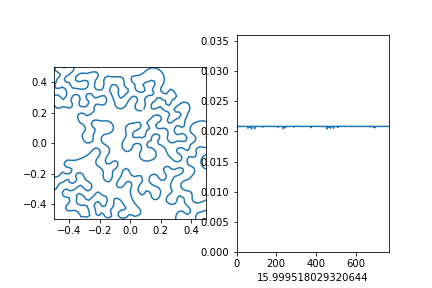

In [125]:
%matplotlib notebook
fig = plt.figure()

ax = fig.add_subplot(121)
#ax.axis(np.array([-0.28,-0.26,0.26,0.28]))
#ax.axis(np.array([0.21,0.24,-0.44,-0.42]))
ax.axis(np.array([-0.5,0.5,-0.5,0.5]))
ax.axes.set_aspect(1)
line = plt.Line2D(points_new.coords[:,0],points_new.coords[:,1])#,marker='*',markersize=2)
ax.add_line(line)
bx = fig.add_subplot(122)
#bx.axis(np.array([900,950,0.0045,0.0015]))
bx.axis(np.array([0,m,0.000,1/np.sqrt(m)]))
bx.set_xlabel(np.sum(energy._eval_lengths(points_new.coords)))
distance = plt.Line2D(np.linspace(0,m,m),energy._eval_lengths(points_new.coords))
bx.add_line(distance)
def update_points(p):
    line.set_xdata(p.coords[:,0])
    line.set_ydata(p.coords[:,1])
    distance.set_ydata(energy._eval_lengths(p.coords))
    bx.set_xlabel(np.sum(energy._eval_lengths(p.coords)))
    fig.canvas.draw()
    return


In [126]:
#energy._alpha =.00000010
energy._L =np.sqrt(m/3)#15#3.030#
energy._alpha = 10000/energy._L**5#2**(-5/2*9)/10
method= lorm.optim.ConjugateGradientMethod(max_iter=50,tol_grad=1e-12)
method.listener = update_points
#points_new.coords[:] = points.coords[:]
for i in range(1):
    points_new = method.run(energy,points_new)

Initial value: f[0] = 0.0012303393813939715
f[1] = 0.001007105771336668
f[2] = 0.0008788518421295492
f[3] = 0.0007954307674782983
f[4] = 0.0007465302136632616
f[5] = 0.0007140073633778733
f[6] = 0.0007040471567955045
f[7] = 0.0007005716374809319
f[8] = 0.0006988250641488219
f[9] = 0.000697962067147802
f[10] = 0.0006972309533233947
f[11] = 0.0006968642014674931
f[12] = 0.0006964305764953175
f[13] = 0.0006959364913156656
f[14] = 0.000695221321955947
f[15] = 0.0006944759532125886
f[16] = 0.0006937952884593747
f[17] = 0.0006932438139905774
f[18] = 0.0006926269781578135
f[19] = 0.000692130786748099
f[20] = 0.0006916474557270211
f[21] = 0.0006911695317131581
f[22] = 0.0006906778880411057
f[23] = 0.0006902343719994098
f[24] = 0.0006898847261796636
f[25] = 0.0006895679185582189
f[26] = 0.0006892033393117659
f[27] = 0.0006888475077988937
f[28] = 0.0006885183723268545
f[29] = 0.0006882254711318213
f[30] = 0.000688007051938085
f[31] = 0.0006878110889842941
f[32] = 0.0006876437828721687
f[33] = 0.

In [68]:
np.sum((m*energy._eval_lengths(points_new.coords)-energy._L)<0)

93

In [107]:
np.sum(energy._eval_lengths(points_new.coords))

31.98708263237529

In [117]:
"tiger_{}.txt".format(1)

'tiger_1.txt'

In [129]:
#points_new.coords = temp
tempc = points_new.coords
m2 = len(tempc)
temp = np.zeros([2*m2,2])
for i in range(m2):
    temp[2*i,:] = tempc[i,:]
for i in range(m2-1):
    temp[2*i+1,:] = (tempc[i,:]+tempc[i+1,:])/2
temp[2*m2-1,:] = (tempc[0,:]+tempc[m2-1,:])/2

m = len(temp)
points.coords = temp